# KNN for outliers detection

This notebook attempts to use KNN for outlier detection and automate auto-tuning of the parameters. 

Reference:

1. [KNN for anamoly](https://medium.com/@gabrielpierobon/k-nearest-neighbors-knn-for-anomaly-detection-d9bcc2d4f71a)
    - Github nb: https://github.com/gabrielpierobon/anomaly_detection/blob/main/Chapter%2009%20K-Nearest%20Neighbors%20(KNN)%20for%20Anomaly%20Detection.ipynb

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# Seed for reproducibility
np.random.seed(1)

## Synthetic dataset
We first start with a synthetic dataset to understand the basics of KNN anomaly detection.

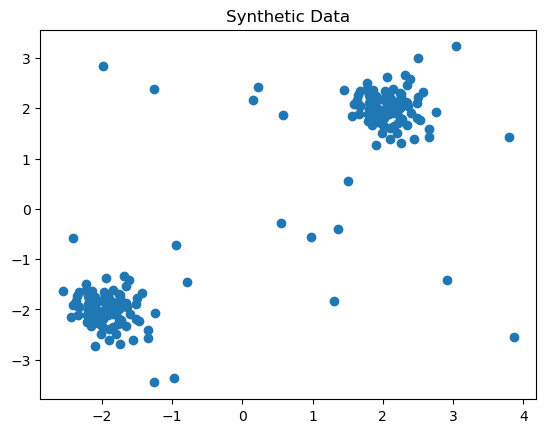

In [2]:
# Generate training data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Combine the two datasets
X = np.r_[X_inliers, X_outliers]

# Plot the data
plt.scatter(X[:, 0], X[:, 1])
plt.title("Synthetic Data")
plt.show()

In the plot below, the blue points are the normal data points whereas the orange points are the detected anomalies.

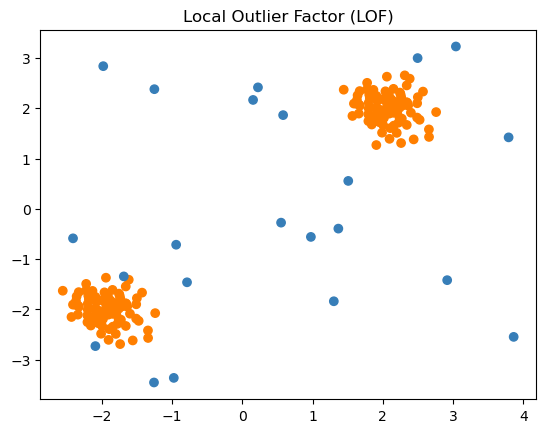

In [3]:
# Fit the model
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)

# Generate colors based on the prediction
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], color=colors[(y_pred + 1) // 2])
plt.title("Local Outlier Factor (LOF)")
plt.show()

## Real-world dataset
Here, we will then be using the "Credit Card Fraud Detection" dataset from [Kaggle](https://www.kaggle.com/datasets/arockiaselciaa/creditcardcsv?select=creditcard.csv). It consists of transactions made by credit cards, where the positive class (frauds)
account for only 0.172% of all transactions.

In [4]:
# Import necessary libraries
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

The dataset contains only numerical input variables which are the result of a PCA transformation.

Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
- Time: contains the seconds elapsed between each transaction and the first transaction in the dataset
- Amount: The transaction amount
- Class: response variable and it takes value 1 in case of fraud and 0 otherwise

In [5]:
# Load the dataset
data = pd.read_csv('creditcard.csv')

# Take a look at the data
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Exploration of the dataset

In [6]:
print(data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


### Sample dataset

In [7]:
# Set the fraction of data to sample
fraction = 0.1

# We will use stratified sampling to maintain the ratio of anomalies
stratified_data = data.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=fraction))

# Separate out the features and labels
X_sample = stratified_data.drop('Class', axis=1)
y_sample = stratified_data['Class']

# Standardize the features to have a mean of ~ 0 and a variance of 1
scaler = StandardScaler()
X_std_sample = scaler.fit_transform(X_sample)

### Train model
Finally, after sampling the dataset, we start to train our KNN models. Here, we adopted two kinds of anomalty detection: novelty and outlier.

Novelty trains on only the normal trascations and looks for the "strange" data points and mark it as outlier, while the default outlier trains on the whole transaction and looks for data points that have a substantially lower density than their neighbors

#### Novelty

In [8]:
# Train the model
# Note that this is novelty detection so we only train on normal transactions
model = LocalOutlierFactor(n_neighbors=20, novelty=True)
model.fit(X_std_sample[y_sample == 0])  # train the model on the normal transactions

# Predict the labels for the entire dataset
y_pred = model.predict(X_std_sample)

# Convert the prediction values to match with 'Class' column in the original dataset
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# Print the confusion matrix
print(confusion_matrix(y_sample, y_pred))

[[26918  1514]
 [    9    40]]


In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_sample, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     28432
           1       0.03      0.82      0.05        49

    accuracy                           0.95     28481
   macro avg       0.51      0.88      0.51     28481
weighted avg       1.00      0.95      0.97     28481



#### Outlier

In [10]:
# Train the model and predict the labels for the entire dataset
model = LocalOutlierFactor(n_neighbors=20, novelty=False)
y_pred = model.fit_predict(X_std_sample)

# Convert the prediction values to match with 'Class' column in the original dataset
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

# Print the confusion matrix
print(confusion_matrix(y_sample, y_pred))

[[26637  1795]
 [   35    14]]


In [11]:
print(classification_report(y_sample, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     28432
           1       0.01      0.29      0.02        49

    accuracy                           0.94     28481
   macro avg       0.50      0.61      0.49     28481
weighted avg       1.00      0.94      0.97     28481



From the results, we could observe that novelty did a better job than outlier, scoring a 0.78 on recall (which we care more in this case) for fraud while outlier only scores a 0.45

## Timeseries data
And now, we are finally trying to using KNN on series data